In [15]:
# !pip install matplotlib seaborn

In [1]:
import pickle
from datasets import Dataset
import pandas as pd
import numpy as np
import pickle
import transformers
from tqdm import tqdm
import torch
from evaluate import load

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import tensorflow as tf

2024-07-29 13:20:25.893196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-29 13:20:25.940661: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 13:20:26.578289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# #I failed to label dsets with allele information, which will be helpful now
# #recover that information

# with open("../data/training_samples_5prev.pkl", 'rb') as f:
#     filter_in_df = pickle.load(f)

# testing_df = filter_in_df.loc[filter_in_df.training == 2].copy()

# test_alleles = testing_df['Allele'].tolist()
# test_lengths = testing_df['Length'].tolist()

# with open("../data/test_dset_prev5.pkl", 'rb') as f:
#     test_dset = pickle.load(f)

# test_dset = test_dset.add_column("allele", test_alleles)
# test_dset = test_dset.add_column('peptide_length', test_lengths)

# with open("../data/test_dset_prev5_add_columns.pkl", "wb") as f:
#     pickle.dump(test_dset, f)

In [ ]:
# training_df = filter_in_df.loc[filter_in_df.training == 1].copy()

# training_alleles = training_df['Allele'].tolist()
# training_lengths = training_df['Length'].tolist()

# with open("../data/train_dset_prev5.pkl", 'rb') as f:
#     training_dset = pickle.load(f)

# training_dset = training_dset.add_column("allele", training_alleles)
# training_dset = training_dset.add_column('peptide_length', training_lengths)

# with open("../data/train_dset_prev5_add_columns.pkl", "wb") as f:
#     pickle.dump(training_dset, f)

In [2]:
from tqdm import tqdm
import tensorflow as tf


with open("../data/train_dset_prev5_add_columns.pkl", 'rb') as f:
     train_dset = pickle.load(f)



model_checkpoint = "esm2_t12_35M_UR50D_MHCI_classification/checkpoint-310935/"
device = torch.device('cuda')
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2).to(device)

#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']



model.eval(); #enable for prediction
final_predictions = []
final_logits = []

with torch.no_grad():
    iterator = 64 #Number of predictions to get with each loop
    for i, n in enumerate(tqdm(range(0, train_dset.num_rows, iterator))):
        try:
            # Retrieve item
            item = train_dset[n:n+iterator]
            sequence = item['input_ids']
            label = item['labels']
            attention_mask = item['attention_mask']
    
            # Generate prediction
            predictions = model(torch.IntTensor(sequence).to(device), torch.IntTensor(attention_mask).to(device))
            final_logits = final_logits + [x for x in predictions['logits'].cpu()]
            ret = [x[1].numpy() for x in tf.nn.sigmoid(predictions['logits'].cpu())]
            final_predictions = final_predictions + ret
        except: #Different lengths occurred... Drat
            for index in range(n, n+iterator):
                item = train_dset[index]
                sequence = [item['input_ids']]
                label = [item['labels']]
                attention_mask = [item['attention_mask']]

                # Generate prediction
                predictions = model(torch.IntTensor(sequence).to(device), torch.IntTensor(attention_mask).to(device))
                final_logits = final_logits + [x for x in predictions['logits'].cpu()]
                ret = [x[1].numpy() for x in tf.nn.sigmoid(predictions['logits'].cpu())]
                final_predictions = final_predictions + ret  
                

        # Predicted class value using argmax
        # predicted_class = np.argmax(prediction)
    
 

  0%|                                                                                         | 0/12956 [00:00<?, ?it/s]2024-07-28 20:00:05.944069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-28 20:00:05.944551: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
100%|██████████████████████████████████████████████████████████████████████████▉| 12955/12956 [2:50:58<00:00,  1.26it/s]


IndexError: Invalid key: 829159 is out of bounds for size 829159

In [4]:
assert(len(final_predictions) == len(train_dset) == len(final_logits))

In [5]:
with open("../data/train_dset_prev5_add_predictions.pkl", 'wb') as f:
     pickle.dump([train_dset, final_logits], f)

In [38]:
from tqdm import tqdm
import tensorflow as tf


with open("../data/test_dset_prev5_add_columns.pkl", 'rb') as f:
     test_dset = pickle.load(f)



model_checkpoint = "esm2_t12_35M_UR50D_MHCI_classification/checkpoint-310935/"
device = torch.device('cuda')
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2).to(device)

#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']



model.eval(); #enable for prediction
final_predictions = []
final_logits = []

with torch.no_grad():

    iterator = 64 #Number of predictions to get with each loop
    for i, n in enumerate(tqdm(range(0, test_dset.num_rows, iterator))):
        try:
            # Retrieve item
            item = test_dset[n:n+iterator]
            sequence = item['input_ids']
            label = item['labels']
            attention_mask = item['attention_mask']
    
            # Generate prediction
            predictions = model(torch.IntTensor(sequence).to(device), torch.IntTensor(attention_mask).to(device))
            final_logits = final_logits + [x for x in predictions['logits'].cpu()]
            ret = [x[1].numpy() for x in tf.nn.sigmoid(predictions['logits'].cpu())]
            final_predictions = final_predictions + ret
        except: #Different lengths occurred... Drat
            for index in range(n, n+iterator):
                item = test_dset[index]
                sequence = [item['input_ids']]
                label = [item['labels']]
                attention_mask = [item['attention_mask']]

                # Generate prediction
                predictions = model(torch.IntTensor(sequence).to(device), torch.IntTensor(attention_mask).to(device))
                final_logits = final_logits + [x for x in predictions['logits'].cpu()]
                ret = [x[1].numpy() for x in tf.nn.sigmoid(predictions['logits'].cpu())]
                final_predictions = final_predictions + ret  
                

        # Predicted class value using argmax
        # predicted_class = np.argmax(prediction)
    
 

100%|██████████████████████████████████████████████████████████████████████████████▉| 4311/4312 [47:35<00:00,  1.51it/s]


IndexError: Invalid key: 275939 is out of bounds for size 275939

In [39]:
assert(len(final_predictions) == len(test_dset) == len(final_logits))

In [ ]:
#Simple 0/1 predictor
#predictions = np.argmax(prediction['logits'], axis=1)
#predictions

In [42]:
test_dset = test_dset.add_column("predicted_val", final_predictions)
#test_dset = test_dset.add_column("final_logits", final_logits)
with open("../data/test_dset_prev5_add_predictions.pkl", 'wb') as f:
     pickle.dump([test_dset, final_logits], f)

In [43]:
test_dset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'allele', 'peptide_length', 'predicted_val'],
    num_rows: 275939
})

In [6]:
with open("../data/test_dset_prev5_add_predictions.pkl", 'rb') as f:
     test_dset, test_logits = pickle.load(f)

/home/jrouhana/.local/lib/python3.8/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [8]:
train_dset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'allele', 'peptide_length'],
    num_rows: 829159
})

In [9]:
#Get calibration curves
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]



In [26]:
train_x = [[float(y) for y in x] for x in final_logits]
test_x = [[float(y) for y in x] for x in test_logits]

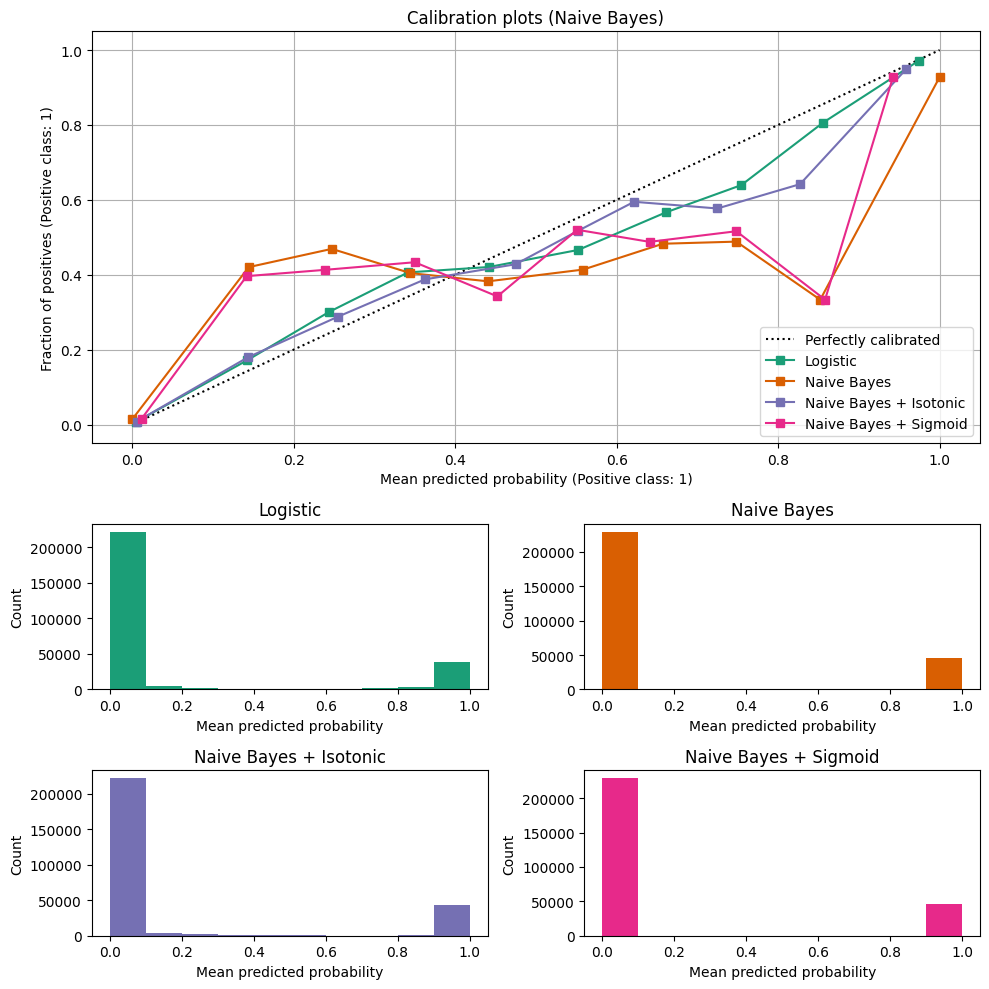

In [27]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

#train_logits = np.array([x for x in final_logits]).reshape(-1, 1)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(train_x, train_dset['labels'])
    display = CalibrationDisplay.from_estimator(
        clf,
        test_x,
        test_dset['labels'],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [34]:
#Get calibration curves
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

regular_sigmoid = CalibratedClassifierCV(None,  method="sigmoid")
regular_isotonic = CalibratedClassifierCV(None,  method="isotonic")

clf_list = [
    (lr, "Logistic"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (regular_sigmoid, "Sigmoid"),
    (regular_isotonic, "Isotonic")
]



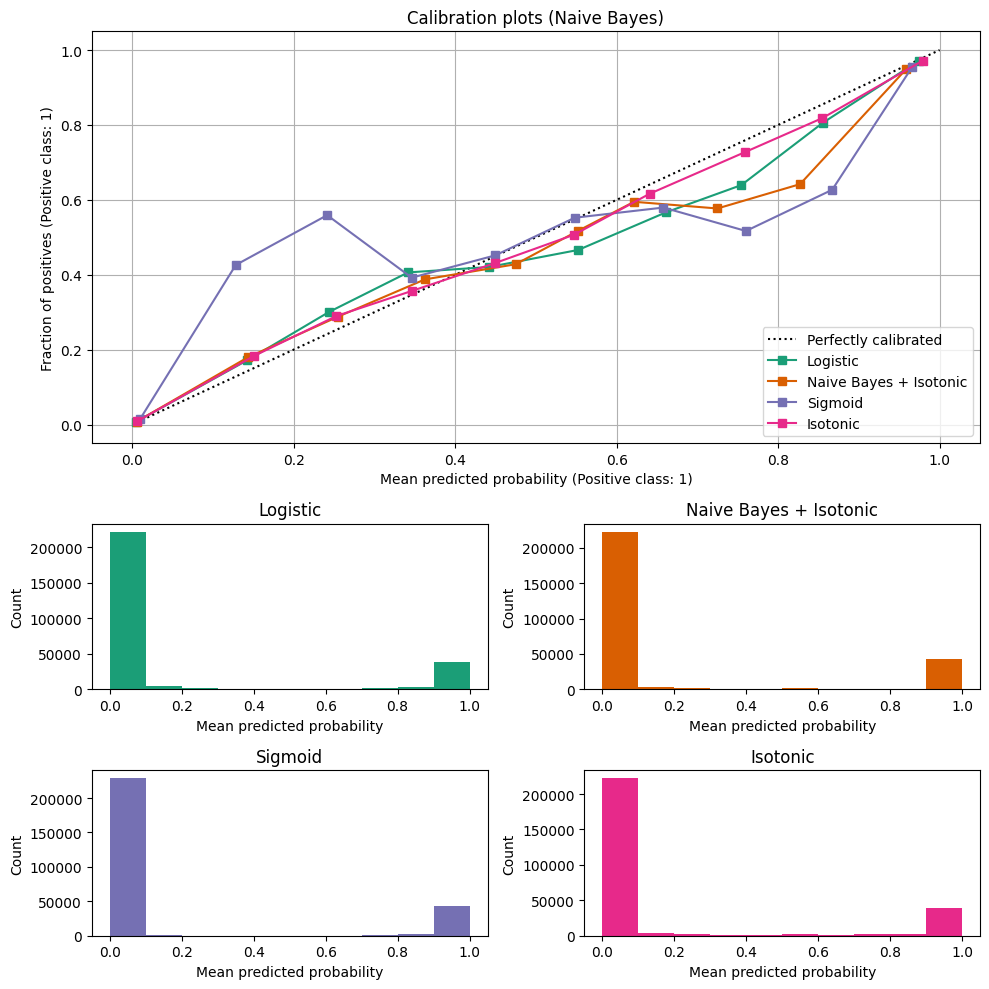

In [35]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

#train_logits = np.array([x for x in final_logits]).reshape(-1, 1)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(train_x, train_dset['labels'])
    display = CalibrationDisplay.from_estimator(
        clf,
        test_x,
        test_dset['labels'],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

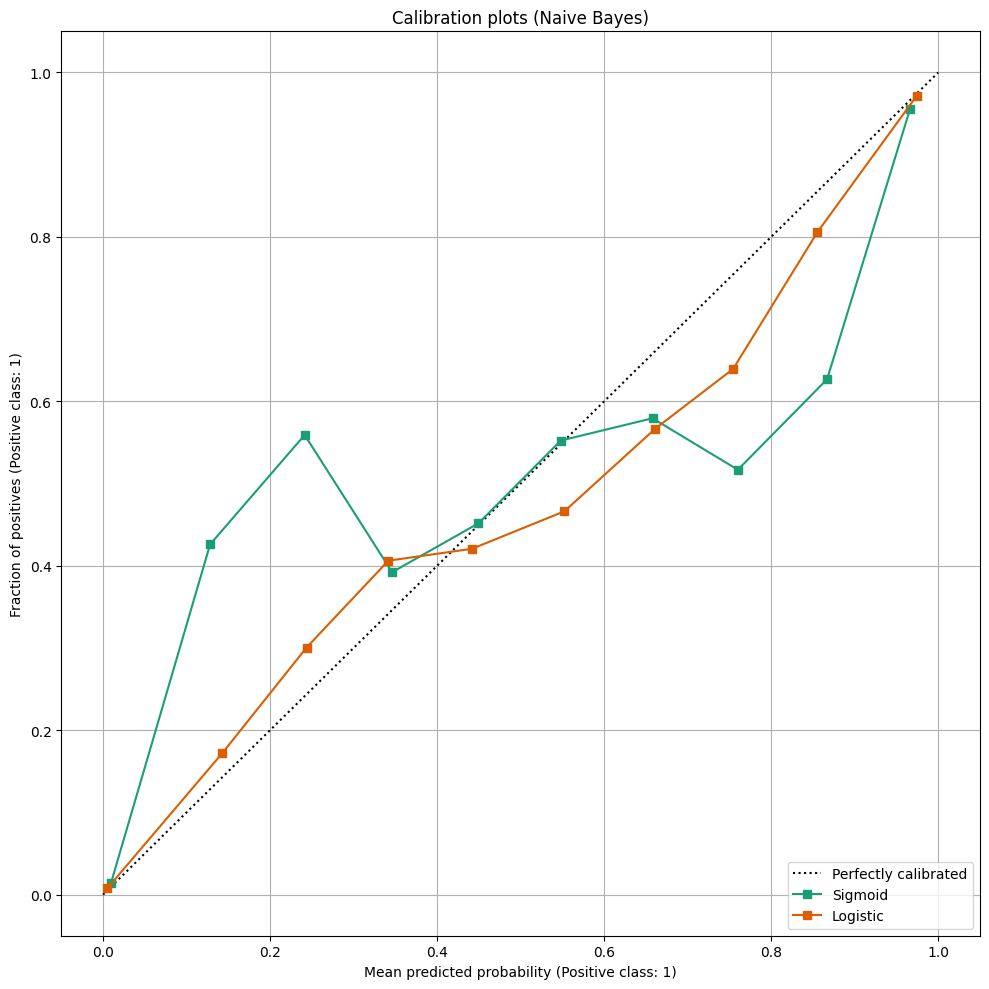

In [41]:
clf_list = [
    (regular_sigmoid, "Sigmoid"),
    (lr, "Logistic")
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2)
colors = plt.get_cmap("Dark2")

#train_logits = np.array([x for x in final_logits]).reshape(-1, 1)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(train_x, train_dset['labels'])
    display = CalibrationDisplay.from_estimator(
        clf,
        test_x,
        test_dset['labels'],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    try:
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")
    except:
        continue

plt.tight_layout()
plt.show()

In [42]:
regular_isotonic = CalibratedClassifierCV(None,  method="isotonic")
regular_isotonic.fit(train_x, train_dset['labels'])

CalibratedClassifierCV(method='isotonic')

In [56]:
test_yhat = regular_isotonic.predict(test_x)
train_yhat = regular_isotonic.predict(train_x)

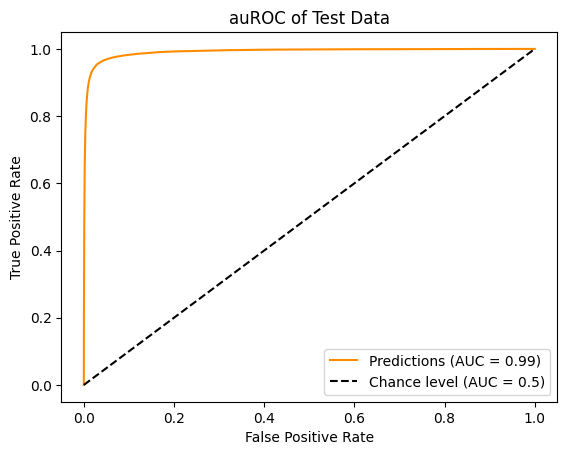

In [69]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    test_dset['labels'],
    [x[1] for x in test_yhat_prob],
    name="Predictions",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="auROC of Test Data",
)

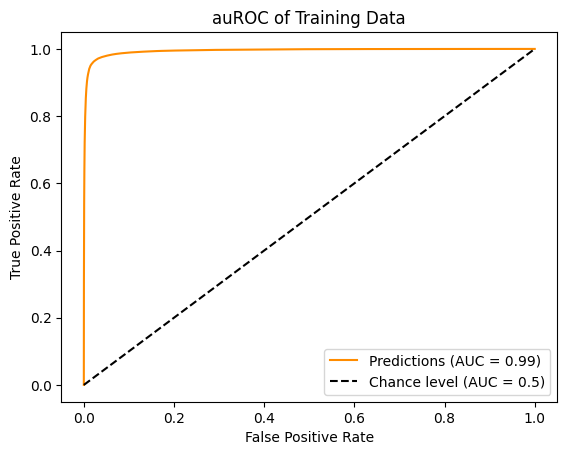

In [68]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    train_dset['labels'],
    [x[1] for x in train_yhat_prob],
    name="Predictions",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="auROC of Training Data",
)

In [59]:
test_yhat_prob = regular_isotonic.predict_proba(test_x)
train_yhat_prob = regular_isotonic.predict_proba(train_x)

Logistic: f1=0.924 auc=0.969


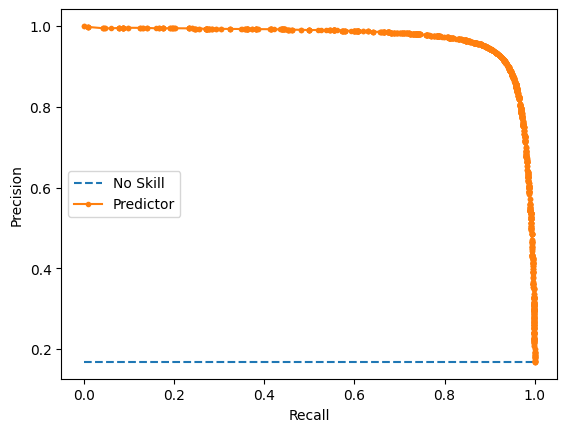

In [82]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

lr_precision, lr_recall, _ = precision_recall_curve(test_dset['labels'], [x[1] for x in test_yhat_prob])
lr_f1, lr_auc = f1_score(test_dset['labels'], test_yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len([x for x in test_dset['labels'] if x ==1]) / len(test_dset['labels'])
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Predictor')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Logistic: f1=0.940 auc=0.978


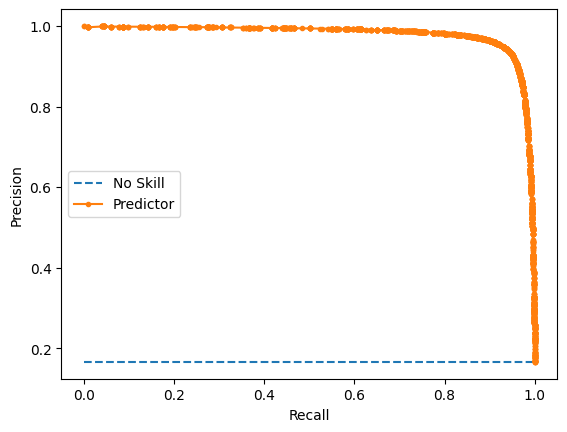

In [83]:
lr_precision, lr_recall, _ = precision_recall_curve(train_dset['labels'], [x[1] for x in train_yhat_prob])
lr_f1, lr_auc = f1_score(train_dset['labels'], train_yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len([x for x in train_dset['labels'] if x ==1]) / len(train_dset['labels'])
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Predictor')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [87]:
print(len([x for x in test_dset['labels'] if x == 0]))
print(len([x for x in test_dset['labels'] if x == 1]))

229509
46430


In [102]:
test_df = test_dset.to_pandas()
test_df['peptide'] = test_df.apply(lambda x: x['input_ids'][(-1*x['peptide_length']):], axis=1)
ninemer_df = test_df.query('peptide_length == 9').copy()
ninemer_df

,input_ids,attention_mask,labels,allele,peptide_length,predicted_val,peptide
780,"[0, 20, 5, 7, 20, 5, 14, 10, 11, 4, 4, 4, 4, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,A0101,9,0.019316,"[11, 13, 12, 12, 4, 19, 5, 8, 2]"
871,"[0, 20, 5, 7, 20, 5, 14, 10, 11, 4, 4, 4, 4, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,A0101,9,0.009821,"[8, 5, 4, 21, 6, 5, 6, 6, 2]"
872,"[0, 20, 5, 7, 20, 5, 14, 10, 11, 4, 4, 4, 4, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,A0101,9,0.028159,"[8, 5, 8, 10, 14, 7, 14, 5, 2]"
873,"[0, 20, 5, 7, 20, 5, 14, 10, 11, 4, 4, 4, 4, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,A0101,9,0.010331,"[15, 15, 16, 9, 4, 16, 21, 18, 2]"
874,"[0, 20, 5, 7, 20, 5, 14, 10, 11, 4, 4, 4, 4, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,A0101,9,0.010722,"[6, 19, 13, 16, 19, 13, 13, 4, 2]"
...,...,...,...,...,...,...,...
275933,"[0, 20, 10, 7, 20, 5, 14, 16, 5, 4, 4, 4, 4, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,C1701,9,0.022878,"[8, 17, 7, 23, 9, 9, 19, 12, 2]"
275934,"[0, 20, 10, 7, 20, 5, 14, 16, 5, 4, 4, 4, 4, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,C1701,9,0.010596,"[4, 10, 10, 23, 10, 7, 17, 5, 2]"
275935,"[0, 20, 10, 7, 20, 5, 14, 16, 5, 4, 4, 4, 4, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,C1701,9,0.013500,"[5, 5, 14, 6, 14, 8, 6, 10, 2]"
275936,"[0, 20, 10, 7, 20, 5, 14, 16, 5, 4, 4, 4, 4, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,C1701,9,0.017725,"[9, 17, 12, 14, 4, 4, 12, 5, 2]"


In [103]:
print(len(ninemer_df.loc[ninemer_df.labels == 0]))
print(len(ninemer_df.loc[ninemer_df.labels == 1]))


137466
27912


In [112]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

run_pca_df = pd.DataFrame({1: ninemer_df['peptide'].apply(lambda x: x[0]),
                  2: ninemer_df['peptide'].apply(lambda x: x[1]),
                  3: ninemer_df['peptide'].apply(lambda x: x[2]),
                  4: ninemer_df['peptide'].apply(lambda x: x[3]),
                  5: ninemer_df['peptide'].apply(lambda x: x[4]),
                  6: ninemer_df['peptide'].apply(lambda x: x[5]),
                  7: ninemer_df['peptide'].apply(lambda x: x[6]),
                  8: ninemer_df['peptide'].apply(lambda x: x[7]),
                  9: ninemer_df['peptide'].apply(lambda x: x[8]),
             })

features = run_pca_df.values
x = StandardScaler().fit_transform(features) # normalizing the features

pca_run = PCA(n_components=3)
pca_aas = pca_run.fit_transform(x)

pca_df = pd.DataFrame(data = pca_aas
             , columns = ['pc1', 'pc2', 'pc3'])


In [113]:
pca_df

,pc1,pc2,pc3
0,-0.449186,0.931997,-1.919968
1,-1.839827,0.555157,0.049871
2,-1.159305,-0.033973,0.716535
3,1.598549,-0.079482,-0.851090
4,0.883898,2.015664,0.914891
...,...,...,...
165373,0.974179,1.802314,1.086537
165374,-0.179169,1.782512,0.654184
165375,-1.390719,-0.905961,0.003655
165376,-0.854748,1.255358,0.524420


In [115]:
print('Explained variability per principal component: {}'.format(pca_run.explained_variance_ratio_))


Explained variability per principal component: [0.14256616 0.12542634 0.1234434 ]


<Figure size 640x480 with 0 Axes>

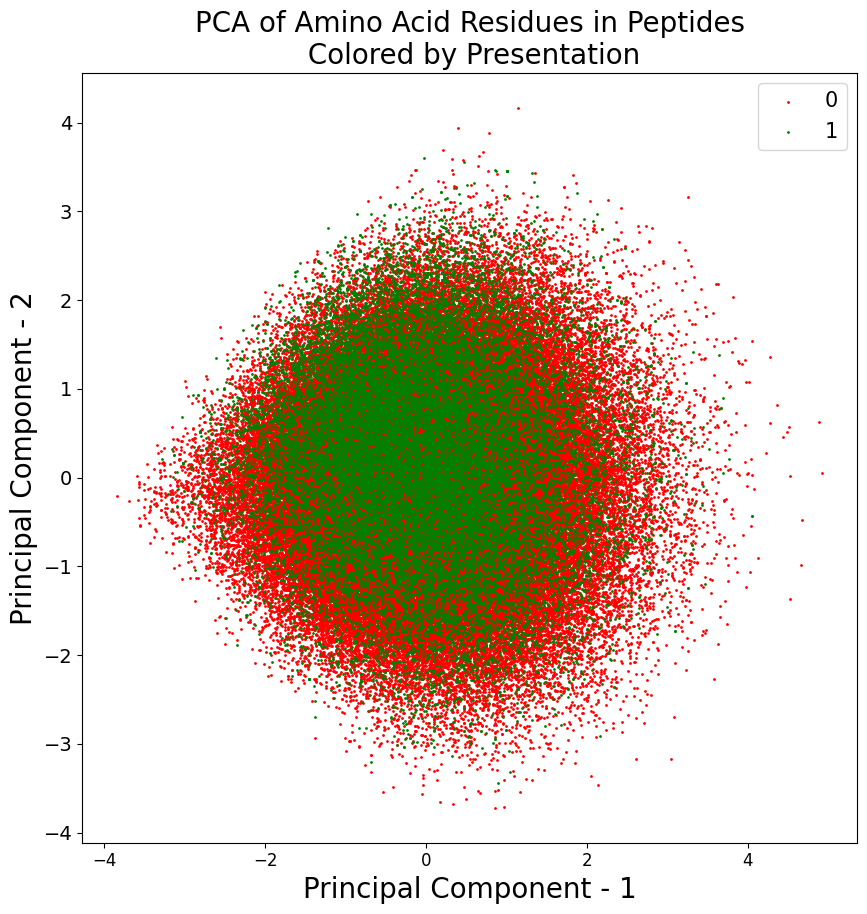

In [126]:
ninemer_df.reset_index(drop=True, inplace=True)

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("PCA of Amino Acid Residues in Peptides\n Colored by Presentation",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = ninemer_df['labels'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'pc1'],
                pca_df.loc[indicesToKeep, 'pc2'], c = color, s = 1)

plt.legend(targets,prop={'size': 15})

<Figure size 640x480 with 0 Axes>

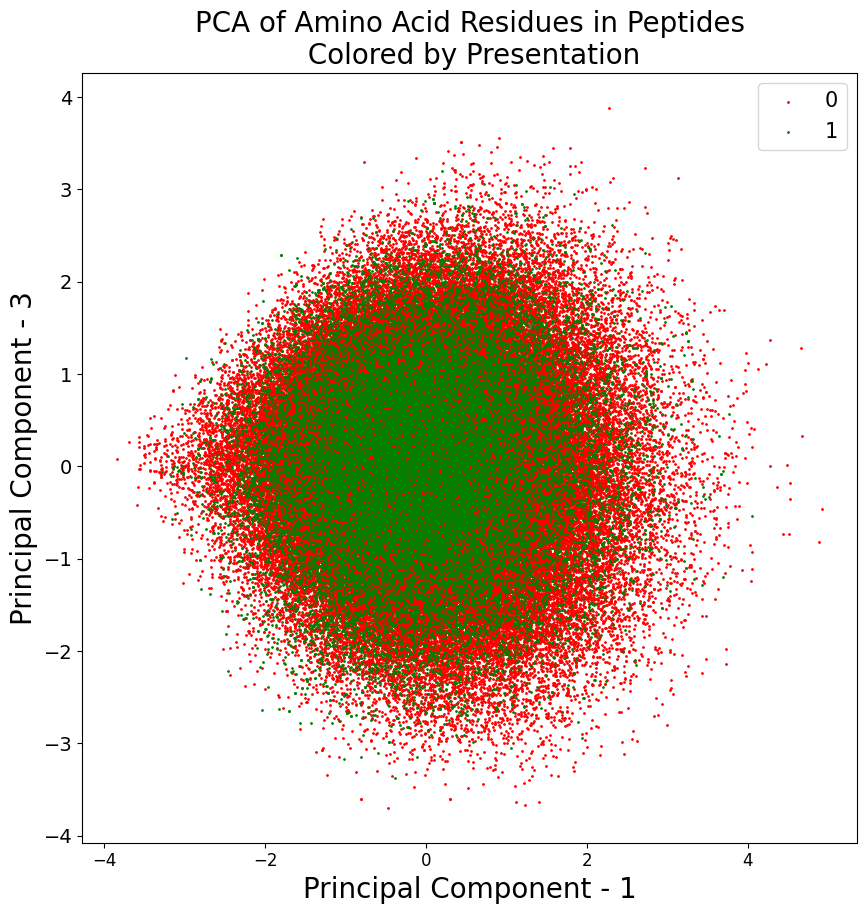

In [125]:
ninemer_df.reset_index(drop=True, inplace=True)

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 3',fontsize=20)
plt.title("PCA of Amino Acid Residues in Peptides\n Colored by Presentation",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = ninemer_df['labels'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'pc1'],
                pca_df.loc[indicesToKeep, 'pc3'], c = color, s = 1)

plt.legend(targets,prop={'size': 15})

<Figure size 640x480 with 0 Axes>

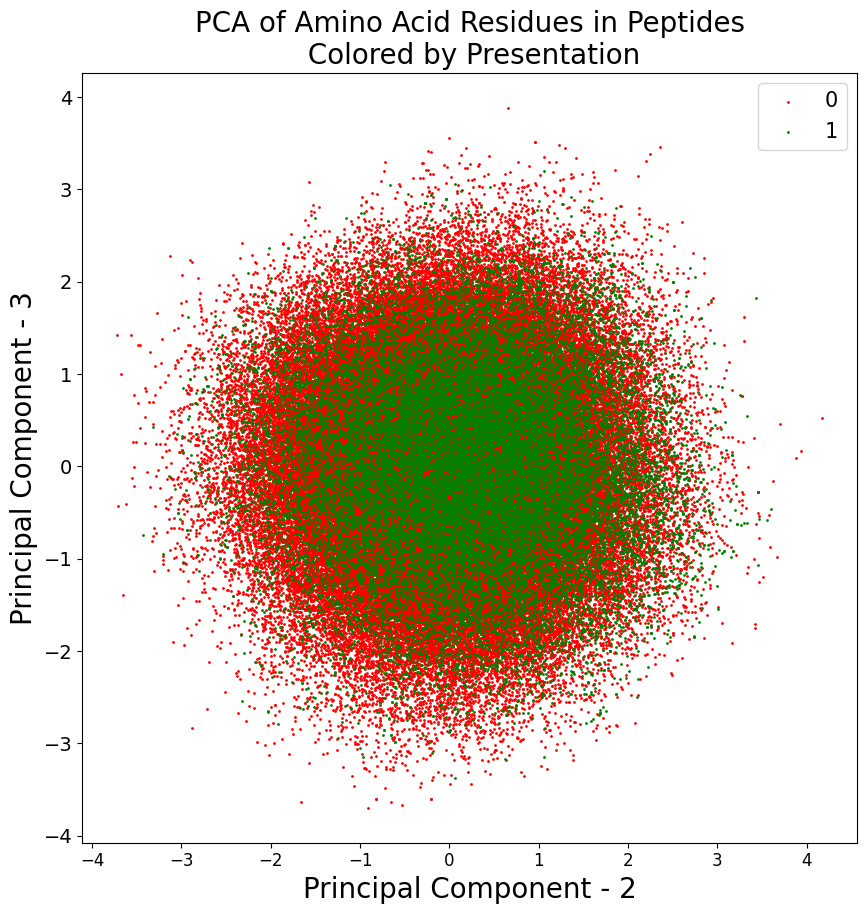

In [124]:
ninemer_df.reset_index(drop=True, inplace=True)

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 2',fontsize=20)
plt.ylabel('Principal Component - 3',fontsize=20)
plt.title("PCA of Amino Acid Residues in Peptides\n Colored by Presentation",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = ninemer_df['labels'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'pc2'],
                pca_df.loc[indicesToKeep, 'pc3'], c = color, s = 1)

plt.legend(targets,prop={'size': 15})

In [134]:
#Sample down negative ninemers so it's more obvious
pca_df['labels'] = ninemer_df['labels']

negative_pcas  = pca_df.loc[pca_df.labels == 0].copy()
positive_pcas = pca_df.loc[pca_df.labels == 1].copy()

positive_pcas['labels'] = 'presented'
negative_pcas['labels'] = 'negative'
negative_pcas_downsampled = negative_pcas.sample(n=len(positive_pcas))

sampled_pcas = pd.concat([positive_pcas, negative_pcas_downsampled])

sampled_pcas.reset_index(inplace=True, drop=True)

<Figure size 640x480 with 0 Axes>

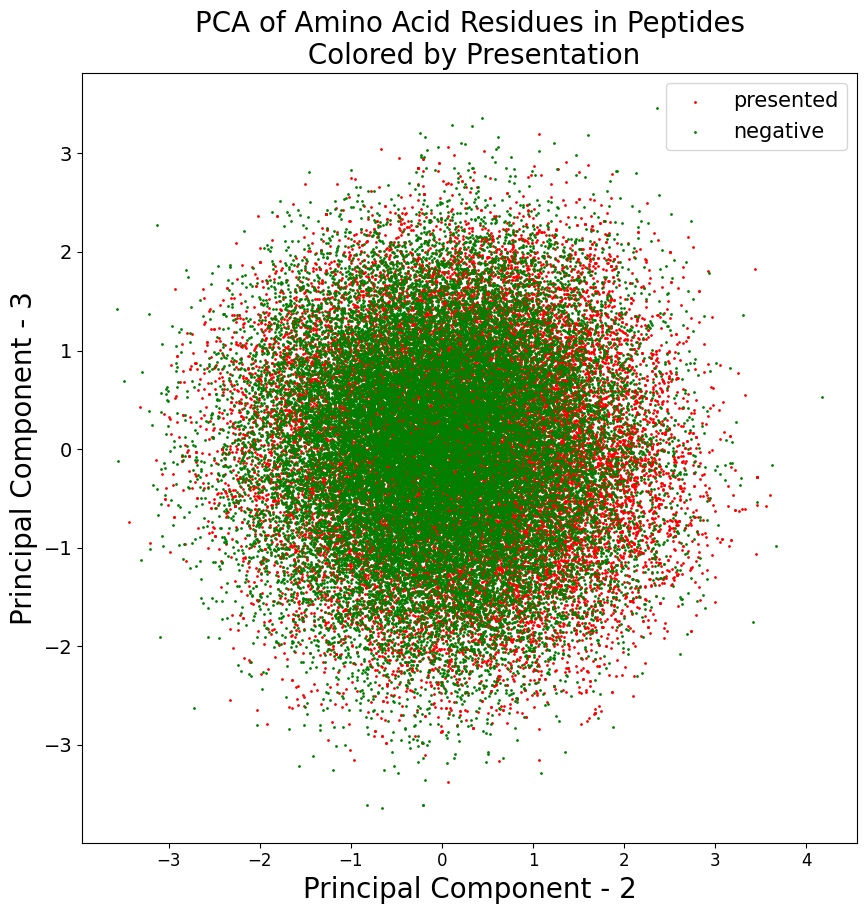

In [135]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 2',fontsize=20)
plt.ylabel('Principal Component - 3',fontsize=20)
plt.title("PCA of Amino Acid Residues in Peptides\n Colored by Presentation",fontsize=20)
targets = ['presented', 'negative']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = sampled_pcas['labels'] == target
    plt.scatter(sampled_pcas.loc[indicesToKeep, 'pc2'],
                sampled_pcas.loc[indicesToKeep, 'pc3'], c = color, s = 1)

plt.legend(targets,prop={'size': 15})

<Figure size 640x480 with 0 Axes>

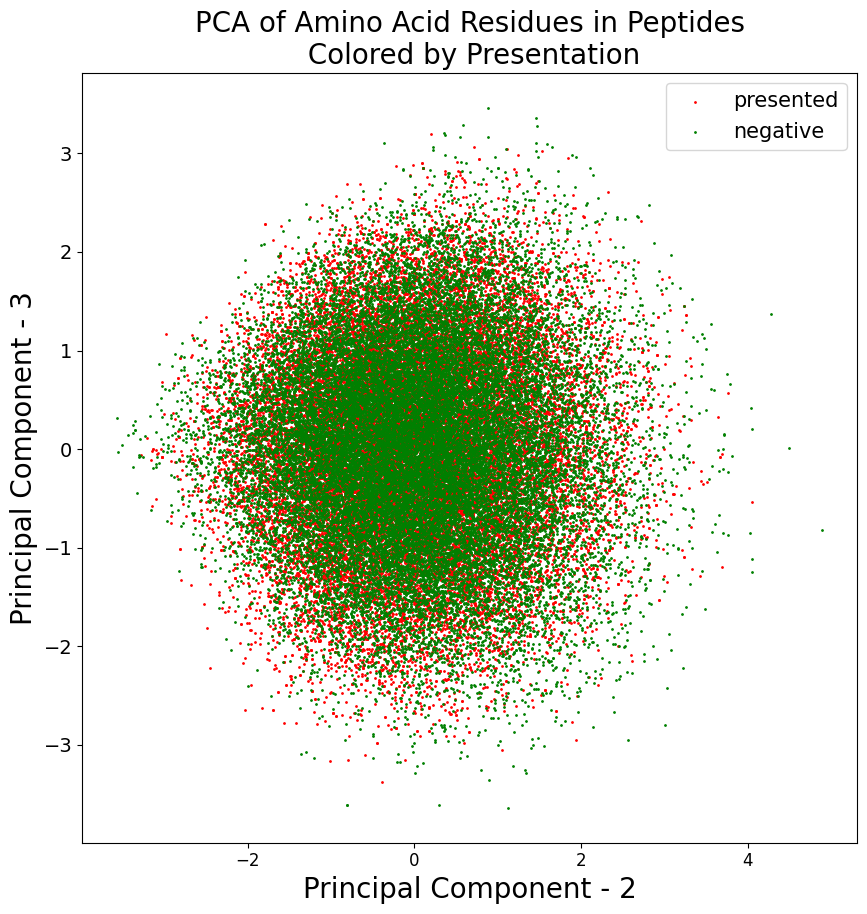

In [136]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 2',fontsize=20)
plt.ylabel('Principal Component - 3',fontsize=20)
plt.title("PCA of Amino Acid Residues in Peptides\n Colored by Presentation",fontsize=20)
targets = ['presented', 'negative']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = sampled_pcas['labels'] == target
    plt.scatter(sampled_pcas.loc[indicesToKeep, 'pc1'],
                sampled_pcas.loc[indicesToKeep, 'pc3'], c = color, s = 1)

plt.legend(targets,prop={'size': 15})

<Figure size 640x480 with 0 Axes>

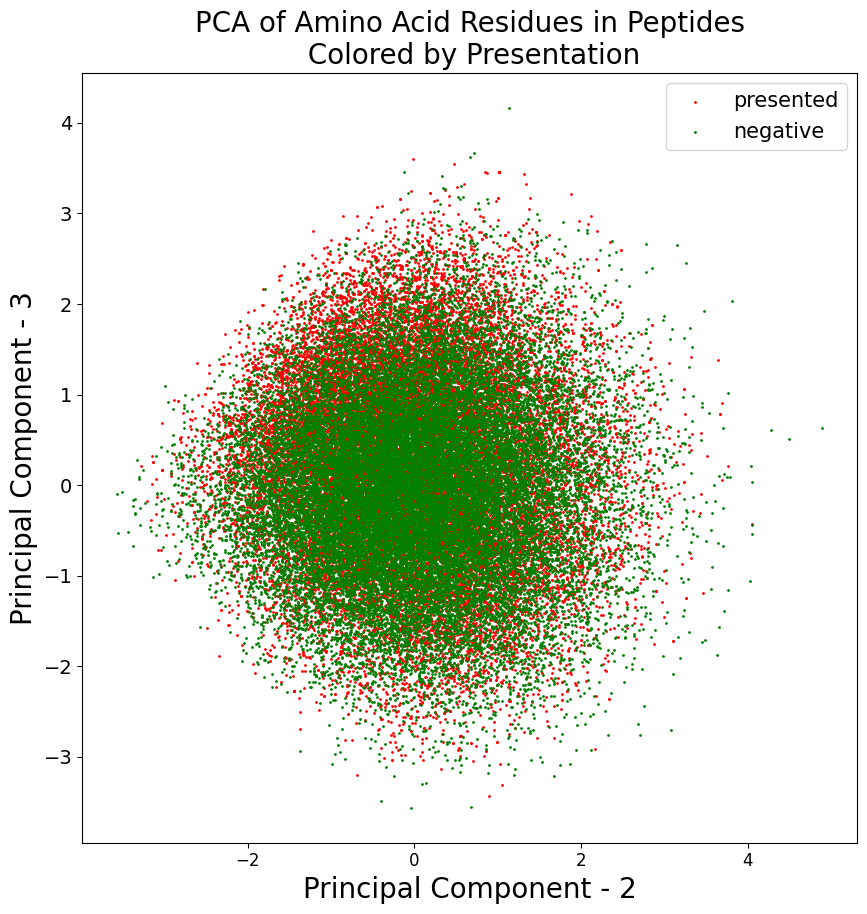

In [137]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 2',fontsize=20)
plt.ylabel('Principal Component - 3',fontsize=20)
plt.title("PCA of Amino Acid Residues in Peptides\n Colored by Presentation",fontsize=20)
targets = ['presented', 'negative']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = sampled_pcas['labels'] == target
    plt.scatter(sampled_pcas.loc[indicesToKeep, 'pc1'],
                sampled_pcas.loc[indicesToKeep, 'pc2'], c = color, s = 1)

plt.legend(targets,prop={'size': 15})

In [2]:
#Motif analysis. Load back in testing data, check if motifs 
#of positives are somehow different from motifs of negatives

with open("../data/training_samples_5prev.pkl", 'rb') as f:
    filter_in_df = pickle.load( f)

filter_in_df

,Allele,Length,Peptide,label,allele_sequence,predict_on,predict_on_len,training
0,A0101,8,ADMGHLKY,1,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,373,1
1,A0101,11,PEKIAVEIPKR,0,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,376,2
2,A0101,9,GHQVALSSI,0,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,374,1
3,A0101,11,KQKEVFLPSTP,0,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,376,1
4,A0101,11,LLSNSSSLWRS,0,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,376,1
...,...,...,...,...,...,...,...,...
1105093,C1701,9,HSVPPVSRK,0,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,381,2
1105094,C1701,9,HPTDPTVLI,0,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,381,1
1105095,C1701,9,KKKVVFCPV,0,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,381,1
1105096,C1701,9,SEADPQALL,0,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,MRVMAPQALLLLLSGALALIETWAGSHSMRYFYTAVSRPGRGEPRF...,381,1


In [33]:
from Bio import motifs 
from Bio.Seq import Seq 
import logomaker

#For some reason Alphabet is deprecated in Bio
#See if I can reproduce it

class Alphabet():
    def __init__(self, size, alphabet):
        self.size = size
        self.letters = alphabet

#IOPAC_protein = Alphabet(22, [ 'A', 'R', 'N' , 'D', 'C', 'Q',
#                    'E', 'G', 'H', 'I', 'L', 'K', 'M',
#                    'F', 'P', 'O', 'S', 'U', 'T', 'W', 
#                    'Y', 'V' ] )


IOPAC_protein = Alphabet(22, [ 'ARNDCQEGHILKMFPOSUTWYV' ] )

    

filtered_ninemers = filter_in_df.query('Length == 9').copy()
ninemers_training = filtered_ninemers.query('training == 1').copy()
ninemers_testing = filtered_ninemers.query('training == 2').copy()

ninemers_testing_positives = ninemers_testing.query('label == 1').copy()
ninemers_testing_negatives = ninemers_testing.query('label == 0').copy()

aa_motif = [ Seq(x, [ 'ARNDCQEGHILKMFPOSUTWYV' ]) for x in ninemers_testing_positives['Peptide']] 

In [37]:
seq = motifs.create(aa_motif, [ 'A', 'R', 'N' , 'D', 'C', 'Q',
                    'E', 'G', 'H', 'I', 'L', 'K', 'M',
                    'F', 'P', 'S', 'T', 'W', 
                    'Y', 'V' ] )
seq.counts

{'A': [3060.0, 3401.0, 2671.0, 1694.0, 1504.0, 1749.0, 1683.0, 2445.0, 1372.0],
 'R': [2451.0, 748.0, 881.0, 713.0, 1640.0, 1013.0, 1472.0, 1611.0, 1819.0],
 'N': [895.0, 162.0, 1292.0, 1038.0, 1012.0, 824.0, 1053.0, 1029.0, 8.0],
 'D': [732.0, 189.0, 2412.0, 3102.0, 959.0, 635.0, 678.0, 331.0, 6.0],
 'C': [94.0, 12.0, 363.0, 118.0, 185.0, 249.0, 212.0, 358.0, 10.0],
 'Q': [877.0, 1514.0, 991.0, 1223.0, 1032.0, 1159.0, 1551.0, 1691.0, 11.0],
 'E': [1467.0, 2691.0, 730.0, 3707.0, 1353.0, 1000.0, 1844.0, 2860.0, 22.0],
 'G': [1091.0, 300.0, 569.0, 2021.0, 1607.0, 1382.0, 419.0, 985.0, 21.0],
 'H': [1153.0, 1033.0, 887.0, 648.0, 1261.0, 748.0, 1496.0, 892.0, 197.0],
 'I': [1511.0, 1476.0, 2503.0, 889.0, 2243.0, 3252.0, 2009.0, 743.0, 2275.0],
 'L': [1842.0, 3884.0, 2471.0, 1576.0, 2339.0, 3149.0, 3624.0, 2234.0, 9289.0],
 'K': [2168.0, 315.0, 1325.0, 1389.0, 1908.0, 1036.0, 1092.0, 2251.0, 1220.0],
 'M': [692.0, 537.0, 898.0, 230.0, 354.0, 441.0, 466.0, 374.0, 835.0],
 'F': [2113.0, 843.0

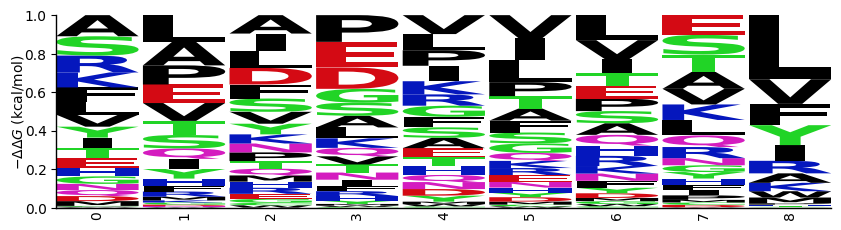

In [55]:
positional_positives_matrix = pd.DataFrame(seq.counts)
positional_positives_weight_matrix = positional_positives_matrix/len(ninemers_testing_positives)

# create Logo object
crp_logo = logomaker.Logo(positional_positives_weight_matrix,
                          shade_below=.5,
                          fade_below=.5)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

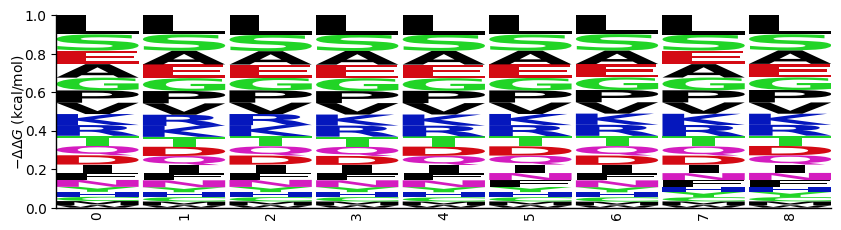

In [60]:

ninemers_testing_negatives = ninemers_testing.query('label == 0').copy()
neg_aa_motif = [ Seq(x, [ 'ARNDCQEGHILKMFPOSUTWYV' ]) for x in ninemers_testing_negatives['Peptide']] 

neg_seq = motifs.create(neg_aa_motif, [ 'A', 'R', 'N' , 'D', 'C', 'Q',
                    'E', 'G', 'H', 'I', 'L', 'K', 'M',
                    'F', 'P', 'S', 'T', 'W', 
                    'Y', 'V' ] )

positional_negatives_matrix = pd.DataFrame(neg_seq.counts)
positional_negatives_weight_matrix = positional_negatives_matrix/len(ninemers_testing_negatives)

# create Logo object
crp_logo = logomaker.Logo(positional_negatives_weight_matrix,
                          shade_below=.5,
                          fade_below=.5)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
crp_logo.ax.set_ylabel("$-\Delta \Delta G$ (kcal/mol)", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

In [67]:
positional_negatives_weight_matrix

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
0,0.070345,0.055643,0.035674,0.048077,0.022449,0.048848,0.070614,0.066249,0.025315,0.043131,0.099799,0.057207,0.021423,0.037020,0.063929,0.084050,0.052515,0.012767,0.026203,0.058742
1,0.071247,0.058123,0.036162,0.047750,0.022995,0.047197,0.071174,0.067006,0.025192,0.042381,0.099777,0.056894,0.019547,0.036729,0.063936,0.085003,0.051475,0.012374,0.025890,0.059149
2,0.069603,0.057512,0.036314,0.047190,0.022827,0.048092,0.068417,0.065733,0.025839,0.042927,0.101691,0.057251,0.019692,0.036474,0.063608,0.085381,0.052864,0.012556,0.026858,0.059171
3,0.071203,0.057331,0.035456,0.046331,0.022915,0.048034,0.070272,0.066998,0.025606,0.043865,0.100912,0.057498,0.019809,0.036264,0.062146,0.085250,0.052122,0.012272,0.026166,0.059549
4,0.071443,0.055657,0.035485,0.047779,0.022005,0.047575,0.070505,0.065682,0.026057,0.043378,0.100934,0.058196,0.018994,0.036183,0.063681,0.084537,0.053024,0.012890,0.026661,0.059331
5,0.071465,0.057171,0.036394,0.047961,0.022355,0.046921,0.070294,0.065122,0.026283,0.043894,0.100287,0.057767,0.019678,0.036147,0.062757,0.083963,0.053170,0.012534,0.026377,0.059447
6,0.070236,0.057272,0.035376,0.048456,0.022769,0.048965,0.069312,0.065674,0.025592,0.044506,0.098664,0.058203,0.019350,0.036038,0.063419,0.085025,0.053279,0.011967,0.026778,0.059120
7,0.069734,0.057971,0.035660,0.047495,0.022355,0.047983,0.070657,0.066213,0.027032,0.043691,0.100941,0.058174,0.019510,0.035056,0.062888,0.082799,0.052922,0.012854,0.026850,0.059215
8,0.070221,0.056203,0.036787,0.048412,0.022857,0.048179,0.070214,0.065543,0.026443,0.043363,0.099101,0.057716,0.020478,0.036082,0.064540,0.083781,0.053664,0.012127,0.025606,0.058684


In [66]:
neg_aa_motif

[Seq('YTDIILYAS'),
 Seq('LSALHGAGG'),
 Seq('SSASRPVPA'),
 Seq('SKKQELQHF'),
 Seq('NGYDQYDDL'),
 Seq('KLNVEERSV'),
 Seq('RDIHPAVWD'),
 Seq('SEQFSSNDA'),
 Seq('DMLGTRMEQ'),
 Seq('PKDGAGRKV'),
 Seq('DSSSKSSIE'),
 Seq('TLGHLSSVL'),
 Seq('GADEEKEQS'),
 Seq('VDLILSLDY'),
 Seq('LLSENHSTV'),
 Seq('ALGAPRVGA'),
 Seq('WYATQLNPA'),
 Seq('GFIPQVNEW'),
 Seq('TSLKLQRDR'),
 Seq('PHAGARRLL'),
 Seq('SQASRLSTQ'),
 Seq('PFPNKDSQL'),
 Seq('LDIESQTCA'),
 Seq('GASNLISSL'),
 Seq('GALAKLGGA'),
 Seq('KDRIRKKES'),
 Seq('GPLDSVTYL'),
 Seq('LKGLLQVFA'),
 Seq('FFKVNGFSN'),
 Seq('TGPLLEKLQ'),
 Seq('ERIFYLLLQ'),
 Seq('CGIQSFFFL'),
 Seq('RNLLYVADS'),
 Seq('CERLKKLID'),
 Seq('MEPNSDELL'),
 Seq('GKSAPGTAQ'),
 Seq('QGSHGELEA'),
 Seq('NLFIATKQD'),
 Seq('DKDFMTPKT'),
 Seq('PKEACMEIS'),
 Seq('PGQSYQSQS'),
 Seq('PPHGVPMGP'),
 Seq('ELPRLQLEW'),
 Seq('SPPASPAPA'),
 Seq('KHLSRTVNG'),
 Seq('YRYDHSVSN'),
 Seq('LRFNCDQQA'),
 Seq('CPFCPYTAK'),
 Seq('AILALLLAV'),
 Seq('IASNTQSRR'),
 Seq('QGRRRSQAT'),
 Seq('IRAFQHAFS'),
 Seq('IHSVEP